# PET Signal for Labelling
A script to show how to use the PET Signal for labeling tumors.

In [1]:
import os
import h5py
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.util.montage import montage2d

# utility functions
make_proj = lambda x: np.sum(x,1)[::-1]
make_mip = lambda x: np.max(x,1)[::-1]

# Loading and Displaying PET and CT
Here we load the PET, CT and Label data from a _single_ patient and show the projection image for CT, the Maximum Intensity Projection (MIP) view for the PET data and the label data.

In [72]:
patient_index = 0
with h5py.File(os.path.join('..', 'input', 'lab_petct_vox_5.00mm.h5'), 'r') as p_data:
    print('Available keys', list(p_data.keys()))
    id_list = list(p_data['ct_data'].keys())
    ct_image = p_data['ct_data'][id_list[patient_index]].value
    pet_image = p_data['pet_data'][id_list[patient_index]].value
    label_image = p_data['label_data'][id_list[patient_index]].value
    # ask kevin why label_image as below
    #label_image = (p_data['label_data'][id_list[0]].value>0).astype(np.uint8)

Available keys ['ct_data', 'label_data', 'pet_data']


### Projection
Show the projection of the images. This means show a 2D view of the 3D image data.

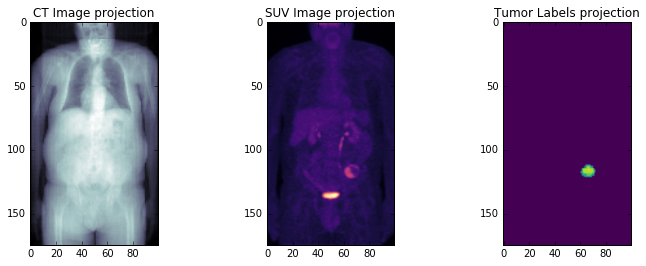

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 4))
ct_proj = make_proj(ct_image)
suv_max = make_mip(pet_image)
lab_proj = make_proj(label_image)

ax1.set_title('CT Image projection')
ax1.imshow(ct_proj, cmap = 'bone')

ax2.set_title('SUV Image projection')
ax2.imshow(np.sqrt(suv_max), cmap = 'magma')

ax3.set_title('Tumor Labels projection')
ax3.imshow(lab_proj, cmap = 'viridis')

## PET Histogram 

Max PET value 42.6068218347


(array([  1.72885200e+06,   4.17000000e+02,   1.37000000e+02,
          6.50000000e+01,   4.90000000e+01,   3.20000000e+01,
          4.10000000e+01,   3.20000000e+01,   3.00000000e+00,
          0.00000000e+00]),
 array([  0.        ,   5.26068218,  10.52136437,  15.78204655,
         21.04272873,  26.30341092,  31.5640931 ,  36.82477528,
         42.08545747,  47.34613965,  52.60682183]),
 <a list of 10 Patch objects>)

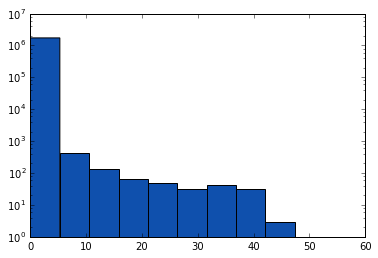

In [50]:
pet_max_value = np.max(pet_image)
print('Max PET value', pet_max_value)
plt.hist(pet_image.ravel(), bins=10, log=True, range=(0, pet_max_value + 10), color='#0f50ad')

## Label Histogram

Max Label value: 2


(array([  1.74951600e+06,   1.00000000e+00,   4.83000000e+02]),
 array([ 0.        ,  0.66666667,  1.33333333,  2.        ]),
 <a list of 3 Patch objects>)

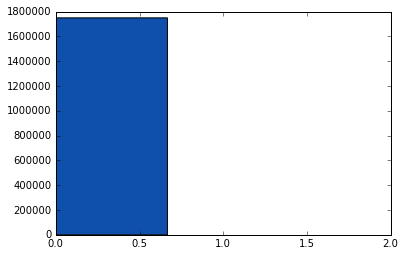

In [71]:
label_max_value = np.max(label_image)
print('Max Label value:', label_max_value)
plt.hist(label_image.ravel(), bins=3, color='#0f50ad')

## Full 3D Superpixels
Here we make full 3D superpixels for PETCT and show a simple rendering of them

In [5]:
pet_weight = 1.0 # how strongly to weight the pet_signal (1.0 is the same as CT)
petct_vol = np.stack([np.stack([(ct_slice+1024).clip(0,2048)/2048, 
                                 pet_weight*(suv_slice).clip(0, pet_max_value)/pet_max_value], -1) 
                      for ct_slice, suv_slice in zip(ct_image, pet_image)], 0)

In [22]:
%%time
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

petct_segs = slic(petct_vol, 
                  n_segments = 20,
                  compactness = 1,
                  multichannel = True)

CPU times: user 1.1 s, sys: 60.4 ms, total: 1.16 s
Wall time: 1.18 s


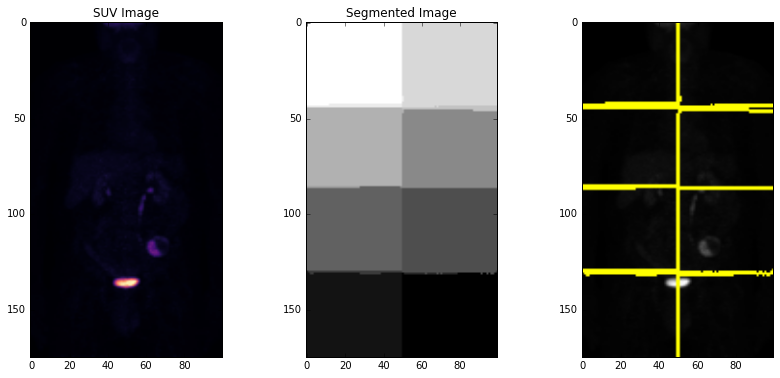

In [24]:
petct_max_segs = make_mip(petct_segs)
ct_proj = make_proj(petct_vol[:,:,:,0])
suv_mip = make_mip(petct_vol[:,:,:,1])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))
ax1.imshow(suv_mip, cmap='magma')
ax1.set_title('SUV Image')
ax2.imshow(petct_max_segs, cmap='gray')
ax2.set_title('Segmented Image')
ax3.imshow(mark_boundaries(suv_mip, petct_max_segs))

## Compare Segments to Labels

We look at each superpixel and see how many different labels are inside it. We want each superpixel to be an 'atomic' unit of the image. So we want 

In [53]:
unique_labels = np.unique(label_image)
for i in unique_labels:
    print('label', i)
    print('counts', pd.value_counts(label_image[i].ravel()), '\n')


label 0
counts 0    10000
dtype: int64 

label 1
counts 0    10000
dtype: int64 

label 2
counts 0    10000
dtype: int64 



In [75]:
print('Distinct values in CT:\t', '{:,}'.format(len(np.unique(ct_image))))
print('Distinct values in PET:\t','{:,}'.format(len(np.unique(pet_image))))
print('Distinct values in Label:\t', len(np.unique(label_image)))

Distinct values in CT:	 1,256,342
Distinct values in PET:	 1,749,966
Distinct values in Label:	 3


In [78]:
for idx in np.unique(petct_segs):
    cur_region_mask = (petct_segs == idx)
    labels_in_region = label_image[cur_region_mask]
    labeled_region_inside = np.unique(labels_in_region)
    if len(labeled_region_inside) > 1:
        print(labeled_region_inside)
        print('\nSuperpixel id', idx, 'regions', len(labeled_regions_inside))
        print(pd.value_counts(labels_in_region))
        print('Missclassified Pixels:', np.sum(pd.value_counts(labels_in_region)[1:].values))

[0 1 2]

Superpixel id 6 regions 1
0    113553
2       483
1         1
dtype: int64
Missclassified Pixels: 484


In [79]:
for idx in np.unique(petct_segs):
    cur_region_mask = (petct_segs == idx)
    labels_in_region = label_image[cur_region_mask]
    labeled_regions_inside = np.unique(labels_in_region)
    if len(labeled_regions_inside) > 1:
        print('\nSuperpixel id', idx, 'regions', len(labeled_regions_inside))
        print(pd.value_counts(labels_in_region))
        print('Missclassified Pixels:', np.sum(pd.value_counts(labels_in_region)[1:].values))


Superpixel id 6 regions 3
0    113553
2       483
1         1
dtype: int64
Missclassified Pixels: 484


In [76]:
pd.value_counts(labels_in_region)[1:].values

array([], dtype=int64)

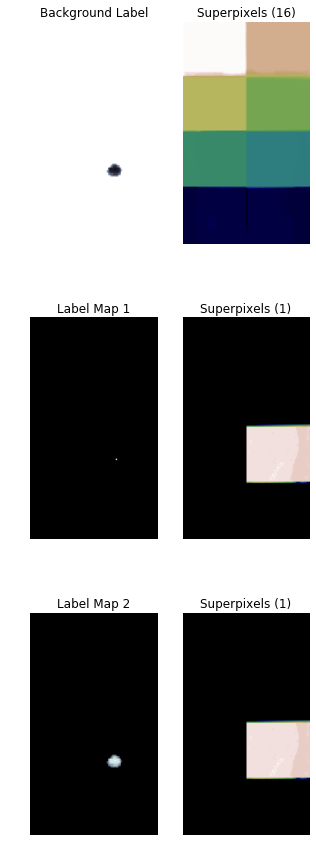

In [77]:
nz_labels = [i for i in np.unique(label_image) if i>=0]
fig, m_axs = plt.subplots(len(nz_labels), 2, figsize = (5, 15))
for (ax1, ax2), i_label in zip(m_axs, nz_labels):
    out_sp = np.zeros_like(petct_segs)
    cur_label_mask = label_image == i_label
    labels_in_region = petct_segs[cur_label_mask]
    
    superpixels_in_region = np.unique(labels_in_region)
    for i, sp_idx in enumerate(superpixels_in_region):
        out_sp[petct_segs == sp_idx] = i+1
    
    ax1.imshow(make_proj(cur_label_mask), cmap = 'bone')
    ax1.set_title('Label Map {}'.format(i_label) if i_label>0 else 'Background Label')
    ax1.axis('off')
    
    ax2.imshow(make_proj(out_sp), cmap = 'gist_earth')
    ax2.set_title('Superpixels ({})'.format(len(superpixels_in_region)))
    ax2.axis('off')

## Show the superpixels for each label
Here we can show which superpixels are inside each label.

In [ ]:
for idx in np.unique(label_image):
    cur_region_mask = label_image == idx
    labels_in_region = petct_segs[cur_region_mask]
    labeled_regions_inside = np.unique(labels_in_region)
    print('Label id', idx, 'superpixels inside', len(labeled_regions_inside))
    #print(pd.value_counts(labels_in_region))

# Optimize Superpixel Size

In [ ]:
def label_score(gt_labels, sp_segs):
    # type: (np.ndarray, np.ndarray) -> float
    """
    Score how well the superpixels match to the ground truth labels. 
    Here we use a simple penalty of number of pixels misclassified
    :param gt_labels: the ground truth labels (from an annotation tool)
    :param sp_segs: the superpixel segmentation
    :return: the score (lower is better)
    """
    out_score = 0
    for idx in np.unique(sp_segs):
        cur_region_mask = sp_segs == idx
        labels_in_region = gt_labels[cur_region_mask]
        out_score += np.sum(pd.value_counts(labels_in_region)[1:].values)
    return out_score

print('Label Score', label_score(label_image, petct_segs))

In [ ]:
# Make new superpixels
def make_superpixel(pet_weight = 1.0, # how strongly to weight the pet_signal (1.0 is the same as CT)
                    n_segments = 1000, # number of segments
                    compactness = 1): # how compact the segments are
    
    t_petct_vol = np.stack([np.stack([(ct_slice+1024).clip(0,2048)/2048, 
                            pet_weight*(suv_slice).clip(0,5)/5.0
                           ],-1) for ct_slice, suv_slice in zip(ct_image, pet_image)],0)
    petct_segs = slic(t_petct_vol, 
                  n_segments = n_segments, 
                  compactness = compactness,
                 multichannel = True)
    return petct_segs

def make_and_score(*args, **kwargs):
    n_segs = make_superpixel(*args, **kwargs)
    return label_score(label_image, n_segs)
# run it quickly with 10000 segments and it should have many fewer misclassified
print('Misclassified Pixels', make_and_score(n_segments = 100000))

In [ ]:
# test 3 different values for n_segments to see how the performance changes
n_segments = [10, 100, 1000]
n_score = [make_and_score(n_segments = c_seg) for c_seg in n_segments]
print(n_score)
plt.plot(n_segments, n_score, 'b-')


In [ ]:
# Optimize the values
from scipy.optimize import fmin

In [ ]:
bright_segs = np.zeros_like(petct_segs)
kept_comps = 0
for i in np.unique(petct_segs):
    if pet_image[petct_segs == i].mean()>1.5:
        bright_segs[petct_segs == i] = 1
        kept_comps+=1
print('Kept', kept_comps,'of', len(np.unique(petct_segs)))
bright_sum_segs = make_proj(bright_segs)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))
ax1.imshow(suv_max, cmap = 'magma')
ax1.set_title('SUV Image')
ax2.imshow(bright_sum_segs, cmap = plt.cm.bone)
ax2.set_title('Segments Image')

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
def show_3d_mesh(image, threshold):
    p = image[::-1].swapaxes(1,2)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.15, edgecolor='none', linewidth = 0.1)
    mesh.set_facecolor([.1, 1, .1])
    mesh.set_edgecolor([1, 0, 0])
    
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    
    ax.view_init(80, 5)
    return fig

In [ ]:
_ = show_3d_mesh(bright_segs, 0)

In [ ]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
def show_pet_3d(image, pet_signal, threshold):
    p = image[::-1].swapaxes(1,2)

    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(121, projection='3d')
    
    verts, faces = measure.marching_cubes(p, 0)
    mesh = Poly3DCollection(verts[faces], alpha=0.15, edgecolor='none', linewidth = 0.1)
    mesh.set_facecolor([.1, 1, .1])
    mesh.set_edgecolor([1, 0, 0])
    
    ax1.add_collection3d(mesh)

    ax1.set_xlim(0, p.shape[0])
    ax1.set_ylim(0, p.shape[1])
    ax1.set_zlim(0, p.shape[2])
    
    ax1.view_init(80, 5)
    
    ax2 = fig.add_subplot(122, projection='3d')
    p_pet = pet_signal[::-1].swapaxes(1,2)
    
    verts, faces = measure.marching_cubes(p_pet, threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.15, edgecolor='none', linewidth = 0.1)
    mesh.set_facecolor([1, 0, .1])
    mesh.set_edgecolor([.1, 0, 1.0])
    
    ax2.add_collection3d(mesh)

    ax2.set_xlim(0, p.shape[0])
    ax2.set_ylim(0, p.shape[1])
    ax2.set_zlim(0, p.shape[2])
    ax2.view_init(80, 5)
    return fig

In [ ]:
bright_seg_pet = pet_image.copy()
bright_seg_pet[bright_segs==0] = 0
_ = show_pet_3d(bright_segs, bright_seg_pet, 1.5)